In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MaxAbsScaler

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.linalg import svds

Plotly 

In [40]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__) # requires version >= 1.9.0

import cufflinks as cf
# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()

2.0.14


# Importing dataset

In [54]:
file='../Ratebeer.csv'

DF = pd.read_csv(file,infer_datetime_format=True,dtype={'Beer_Name':str,'Beer_ID':str,'Brewer_ID':int,'ABV':str,'Beer_Style':str,'Review_Appearance':str,'Review_Aroma':str,'Review_Palate':str,'Review_Taste':str, 'Review_Overall':str,'Review_Time':str,'Review_ProfileName':str,'Review_Text':str})

In [55]:
DF.drop(['Unnamed: 0','index'],axis=1,inplace=True)

In [56]:
Beers_min=DF.groupby(['Beer_ID']).count()['Review_Aroma'].sort_values(ascending=False).to_dict()

Users_min=DF.groupby(['Review_ProfileName']).count()['Review_Aroma'].sort_values(ascending=False).to_dict()

numRatings = 300
numUserRatings =1000

Beers_list=[]
Users_list=[]

for key, value in Beers_min.items():
    if value > numRatings:
        Beers_list.append(key)
del Beers_min

for key, value in Users_min.items():
    if value > numUserRatings:
        Users_list.append(key)
del Users_min

DF = DF[DF['Beer_ID'].isin(Beers_list)]
del Beers_list

DF = DF[DF['Review_ProfileName'].isin(Users_list)]
del Users_list

In [57]:
BeerList = DF['Beer_ID'].unique().tolist()
BeerDict={}
for i in range(len(BeerList)):
    BeerDict[BeerList[i]]=i

In [58]:
def BeerIDNew(num):
    return BeerDict[num]

In [59]:
UserList = DF['Review_ProfileName'].unique().tolist()
UserDict={}
for i in range(len(UserList)):
    UserDict[UserList[i]]=i

In [60]:
def UserIDNew(name):
    return UserDict[name]

In [61]:
DF['User_ID'] = DF['Review_ProfileName'].apply(lambda x: UserIDNew(x))

In [63]:
DF['Beer_ID'] = DF['Beer_ID'].apply(lambda x: BeerIDNew(x))

In [64]:
DF.reset_index(inplace=True)

In [65]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588339 entries, 0 to 588338
Data columns (total 15 columns):
index                 588339 non-null int64
ABV                   588339 non-null object
Beer_ID               588339 non-null int64
Beer_Name             588339 non-null object
Beer_Style            588339 non-null object
Brewer_ID             588339 non-null int64
Review_Appearance     588339 non-null object
Review_Aroma          588339 non-null object
Review_Overall        588339 non-null object
Review_Palate         588339 non-null object
Review_ProfileName    588339 non-null object
Review_Taste          588339 non-null object
Review_Text           588004 non-null object
Review_Time           588339 non-null object
User_ID               588339 non-null int64
dtypes: int64(4), object(11)
memory usage: 67.3+ MB


In [66]:
DF['Review_Time'] = pd.to_datetime(DF['Review_Time'],unit='s')

In [67]:
DF['ABV'] = pd.to_numeric(DF['ABV'],errors='coerce',downcast='float')

In [68]:
DF['Beer_ID'] = pd.to_numeric(DF['Beer_ID'],errors='coerce')

In [69]:
DF.dropna(axis=0,inplace=True)

In [70]:
DF['Beer_ID'] = DF['Beer_ID'].apply(lambda x: int(x))

In [71]:
DF['Review_Month'] = DF['Review_Time'].apply(lambda time: time.month)
DF['Review_Year'] = DF['Review_Time'].apply(lambda time: time.year)

In [72]:
DF.drop(['Review_Time'],axis=1,inplace=True)

In [73]:
DF = DF[DF['Review_Year']!=2012]

In [74]:
DF.rename(columns={'Review_Appearance': 'Review_Appearance(5)', 'Review_Aroma': 'Review_Aroma(10)','Review_Overall':'Review_Overall(20)','Review_Palate':'Review_Palate(5)','Review_Taste':'Review_Taste(10)'},inplace=True)

In [75]:
def ipa(style):
    if ';IPA' in style:
        return 'IPA'
    else:
        return style

In [76]:
DF['Beer_Style'] = DF['Beer_Style'].apply(lambda style: ipa(style))

In [77]:
def witbier(style):
    if ';Witbier' in style:
        return 'Witbier'
    else:
        return style

In [78]:
DF['Beer_Style'] = DF['Beer_Style'].apply(lambda style: witbier(style))

In [79]:
DF['Review_Appearance(5)'] = DF['Review_Appearance(5)'].apply(lambda x: x.split('/')[0])
DF['Review_Aroma(10)'] = DF['Review_Aroma(10)'].apply(lambda x: x.split('/')[0])
DF['Review_Overall(20)'] = DF['Review_Overall(20)'].apply(lambda x: x.split('/')[0])
DF['Review_Palate(5)'] = DF['Review_Palate(5)'].apply(lambda x: x.split('/')[0])
DF['Review_Taste(10)'] = DF['Review_Taste(10)'].apply(lambda x: x.split('/')[0])

In [80]:
DF['Review_Appearance(5)'] = pd.to_numeric(DF['Review_Appearance(5)'])
DF['Review_Aroma(10)'] = pd.to_numeric(DF['Review_Aroma(10)'])
DF['Review_Overall(20)'] = pd.to_numeric(DF['Review_Overall(20)'])
DF['Review_Palate(5)'] = pd.to_numeric(DF['Review_Palate(5)'])
DF['Review_Taste(10)'] = pd.to_numeric(DF['Review_Taste(10)'])

In [89]:
'''UserList = DF['Review_ProfileName'].unique().tolist()

UserDict={}
for i in range(len(UserList)):
    UserDict[UserList[i]]=i

DF['User_ID'] = DF['Review_ProfileName'].apply(lambda x: UserDict[x])

UserList = DF['User_ID'].unique().tolist()

UserListDF=[None]*len(UserList)

for UserID in UserList:
    UserDict={}
    UserID = np.int64(UserID)
    UserBeerList = DF[DF['User_ID']==UserID]['Beer_ID'].tolist()
    UserPosBeerList=[]
    for BeerID in UserBeerList:
        score = DF[(DF['User_ID']==UserID)& (DF['Beer_ID']==BeerID)]['Review_Overall(20)'].values[0]
        if score >= 12:
            UserPosBeerList.append(BeerID)
    UserDict['Beer List'] = UserPosBeerList
    UserListDF[UserID] = UserDict

UserBeer=pd.DataFrame(UserListDF)

UserBeer.to_csv('../RatingsReduzido.csv')'''

In [92]:
file='../RatingsReduzido.csv'

UR = pd.read_csv(file).drop('Unnamed: 0',axis=1)

In [93]:
UR['Beer List'] = UR['Beer List'].apply(lambda x: x.lstrip('[').rstrip(']').split(', '))

In [84]:
#DF.groupby('Review_Year').count()['ABV'].iplot(color='blue',xTitle='Ano',yTitle='Numero de avaliações',theme='white')

In [198]:
DF['Beer_ID'].nunique()

1847

In [199]:
DF['User_ID'].nunique()

746

# Analysis

In [26]:
num_styles=20
ten_mst_rv_styles=list(DF.groupby(['Beer_Style']).count()['Beer_ID'].sort_values(ascending=False).head(num_styles).index.values)
ten_mst_rv_styles

['IPA',
 'Belgian Strong Ale',
 'Imperial Stout',
 'Imperial/Double IPA',
 'Pale Lager',
 'Barley Wine',
 'American Pale Ale',
 'Porter',
 'American Strong Ale',
 'Fruit Beer',
 'Spice/Herb/Vegetable',
 'Brown Ale',
 'Abbey Tripel',
 'Amber Ale',
 'Stout',
 'Premium Bitter/ESB',
 'Belgian Ale',
 'Sour Ale/Wild Ale',
 'German Hefeweizen',
 'Witbier']

In [27]:
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   

In [ ]:
plt.rcParams["axes.labelsize"] = 40

In [ ]:
sns.set_style("whitegrid")

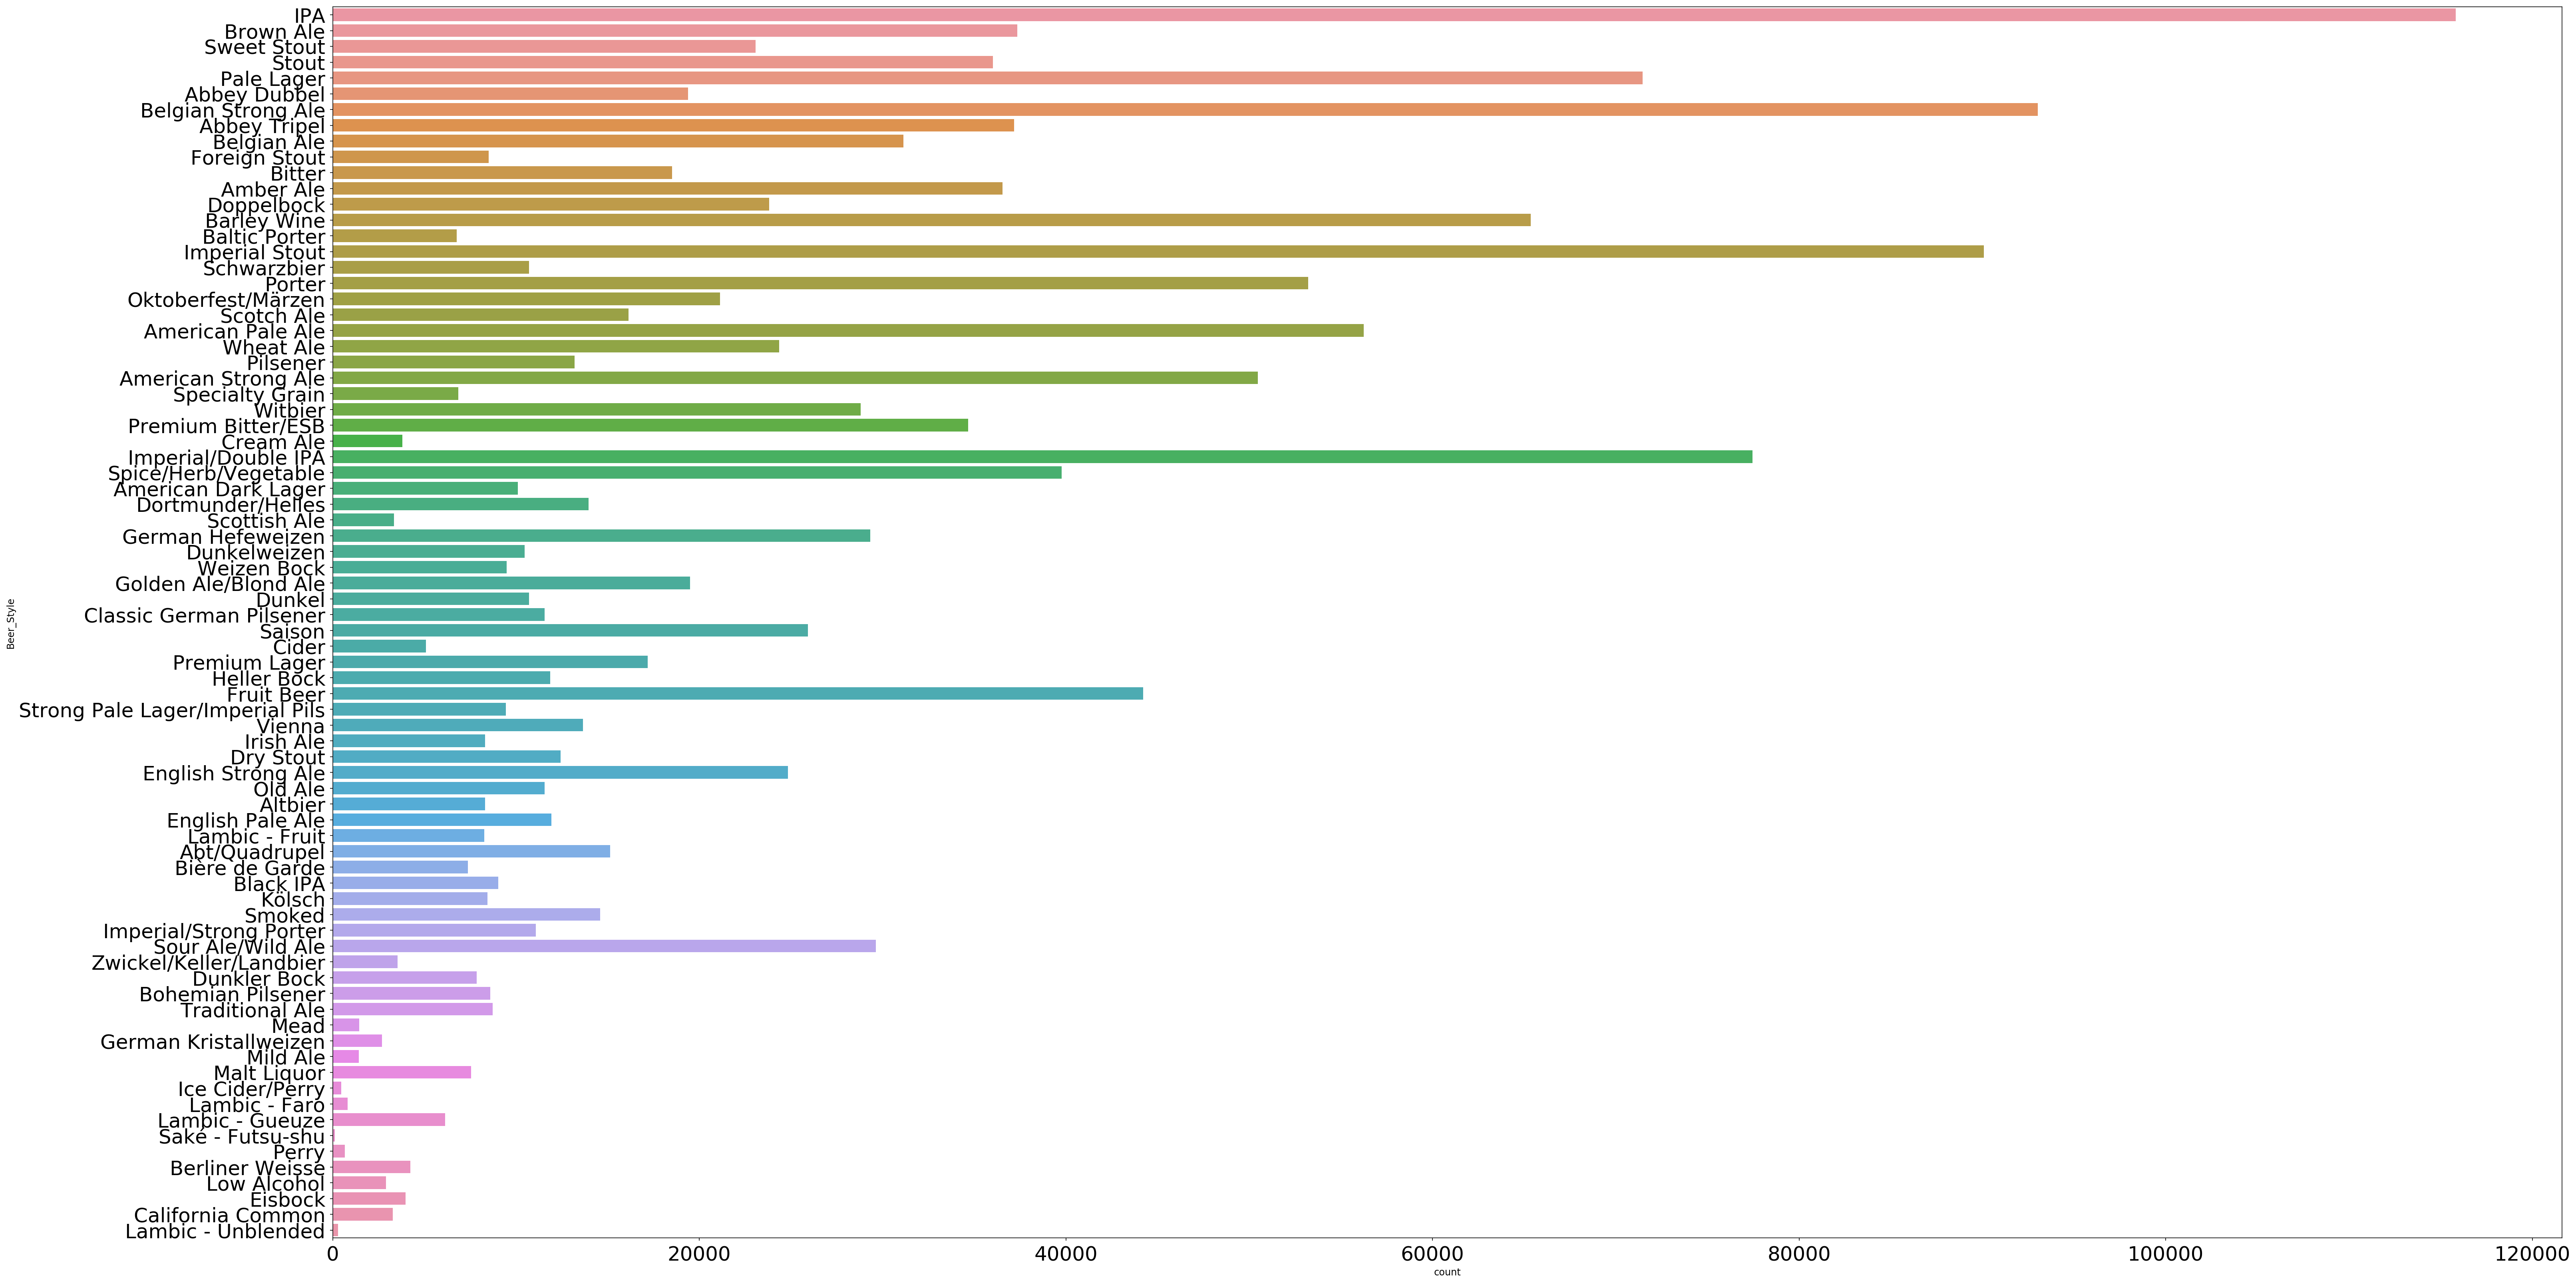

In [28]:
plt.figure(figsize=(45, 22.5))
%config InlineBackend.figure_format = 'retina'

Graph_beer_Styles=sns.countplot(y='Beer_Style',data=DF);#,hue='Review_Year',);
Graph_beer_Styles.tick_params(labelsize=25);
#Graph_beer_Styles.set_xticklabels(Graph_beer_Styles.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout();

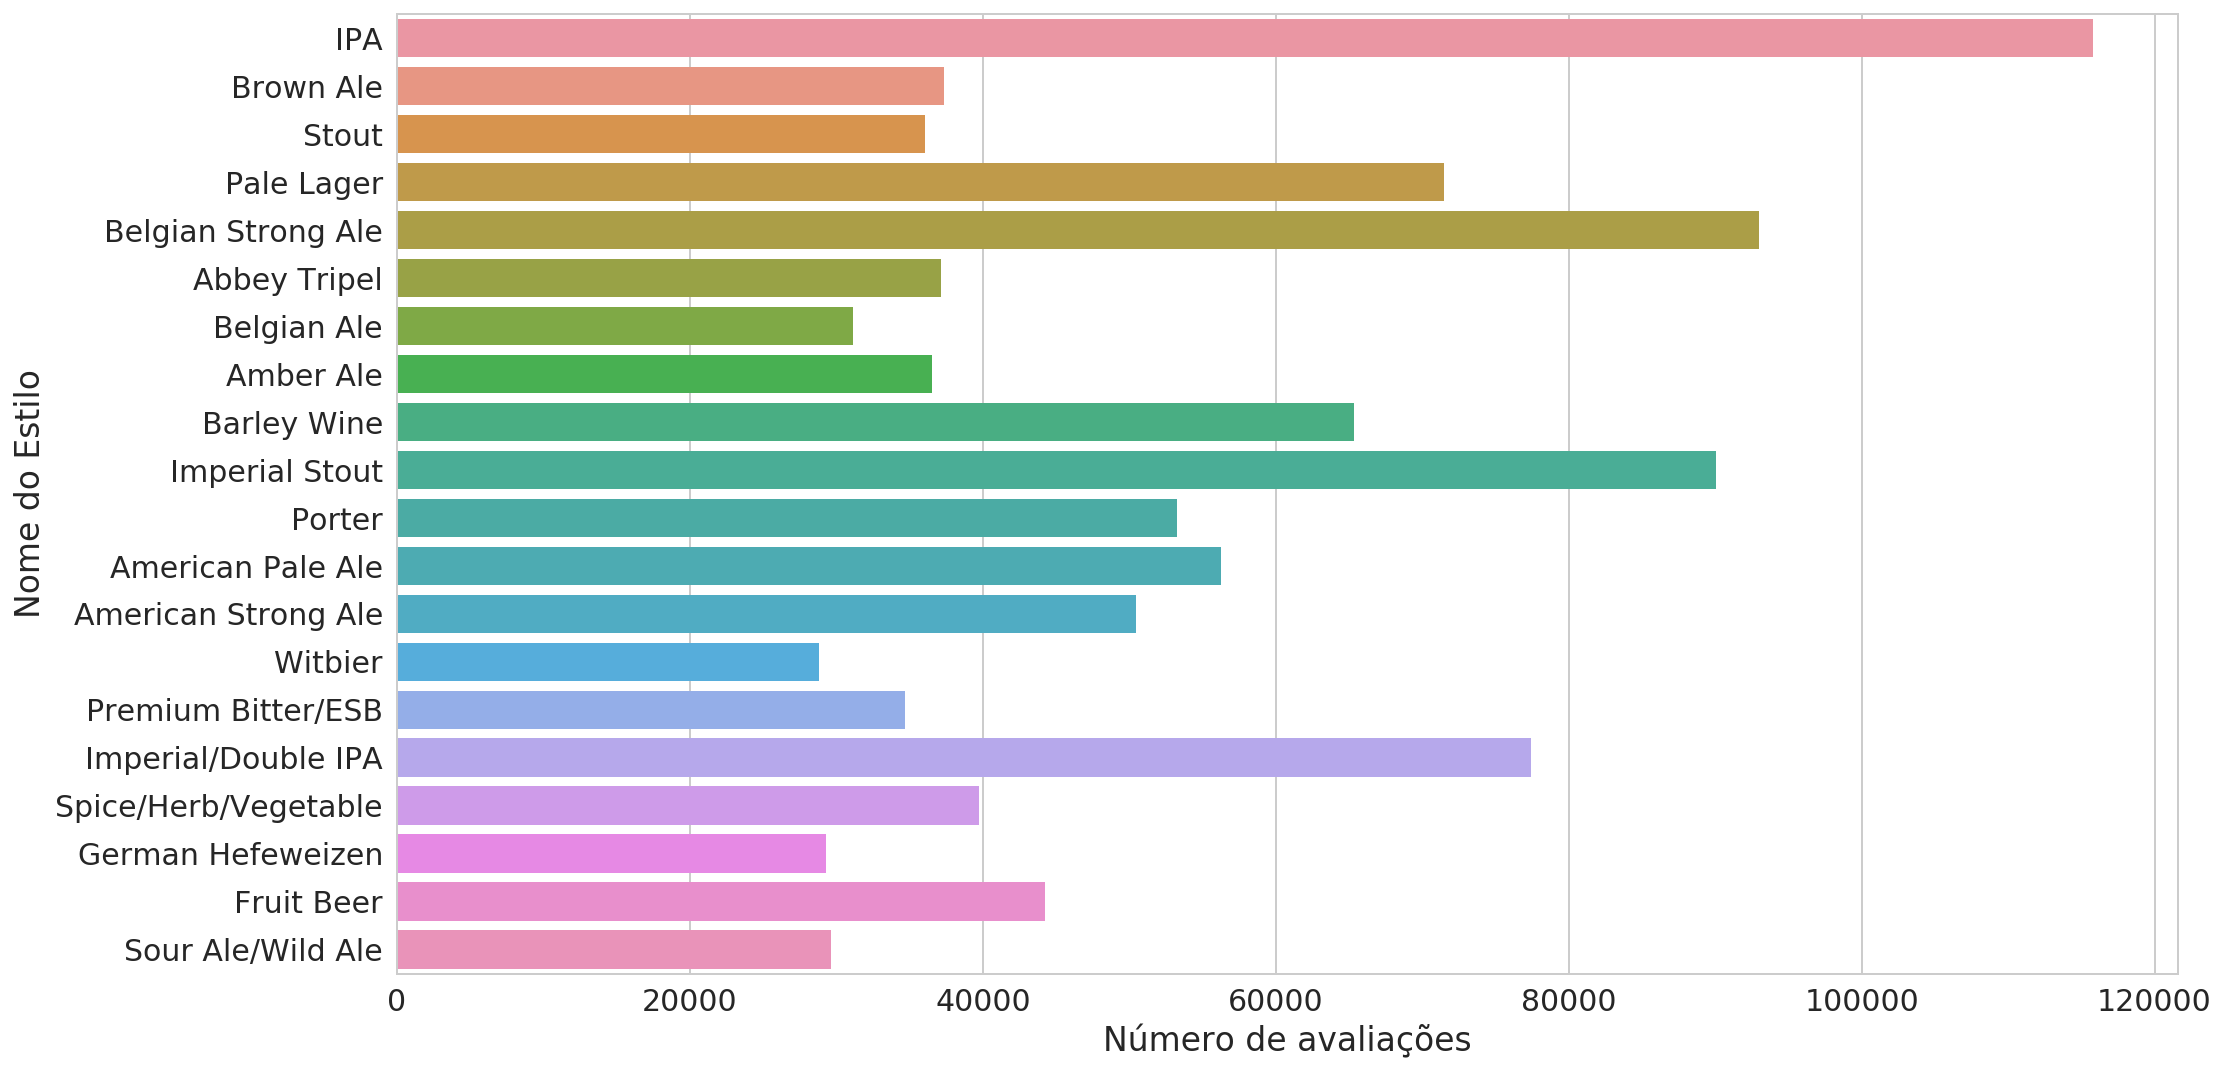

In [32]:
plt.figure(figsize=(16, 8))

#S=sns.set(font_scale=2.1)  # tamanho fontes para eixos

%config InlineBackend.figure_format = 'retina'

Graph_beer_Styles=sns.countplot(y='Beer_Style',data=DF[DF['Beer_Style'].isin(ten_mst_rv_styles)]);#,hue='Review_Year',);
#Graph_beer_Styles.tick_params(labelsize=30);
#Graph_beer_Styles.set_xticklabels(Graph_beer_Styles.get_xticklabels(), rotation=40, ha="right")
sns.set()
sns.set(font_scale = 2)
sns.set_style("whitegrid")
Graph_beer_Styles.set(xlabel='Número de avaliações', ylabel='Nome do Estilo')
plt.tight_layout();

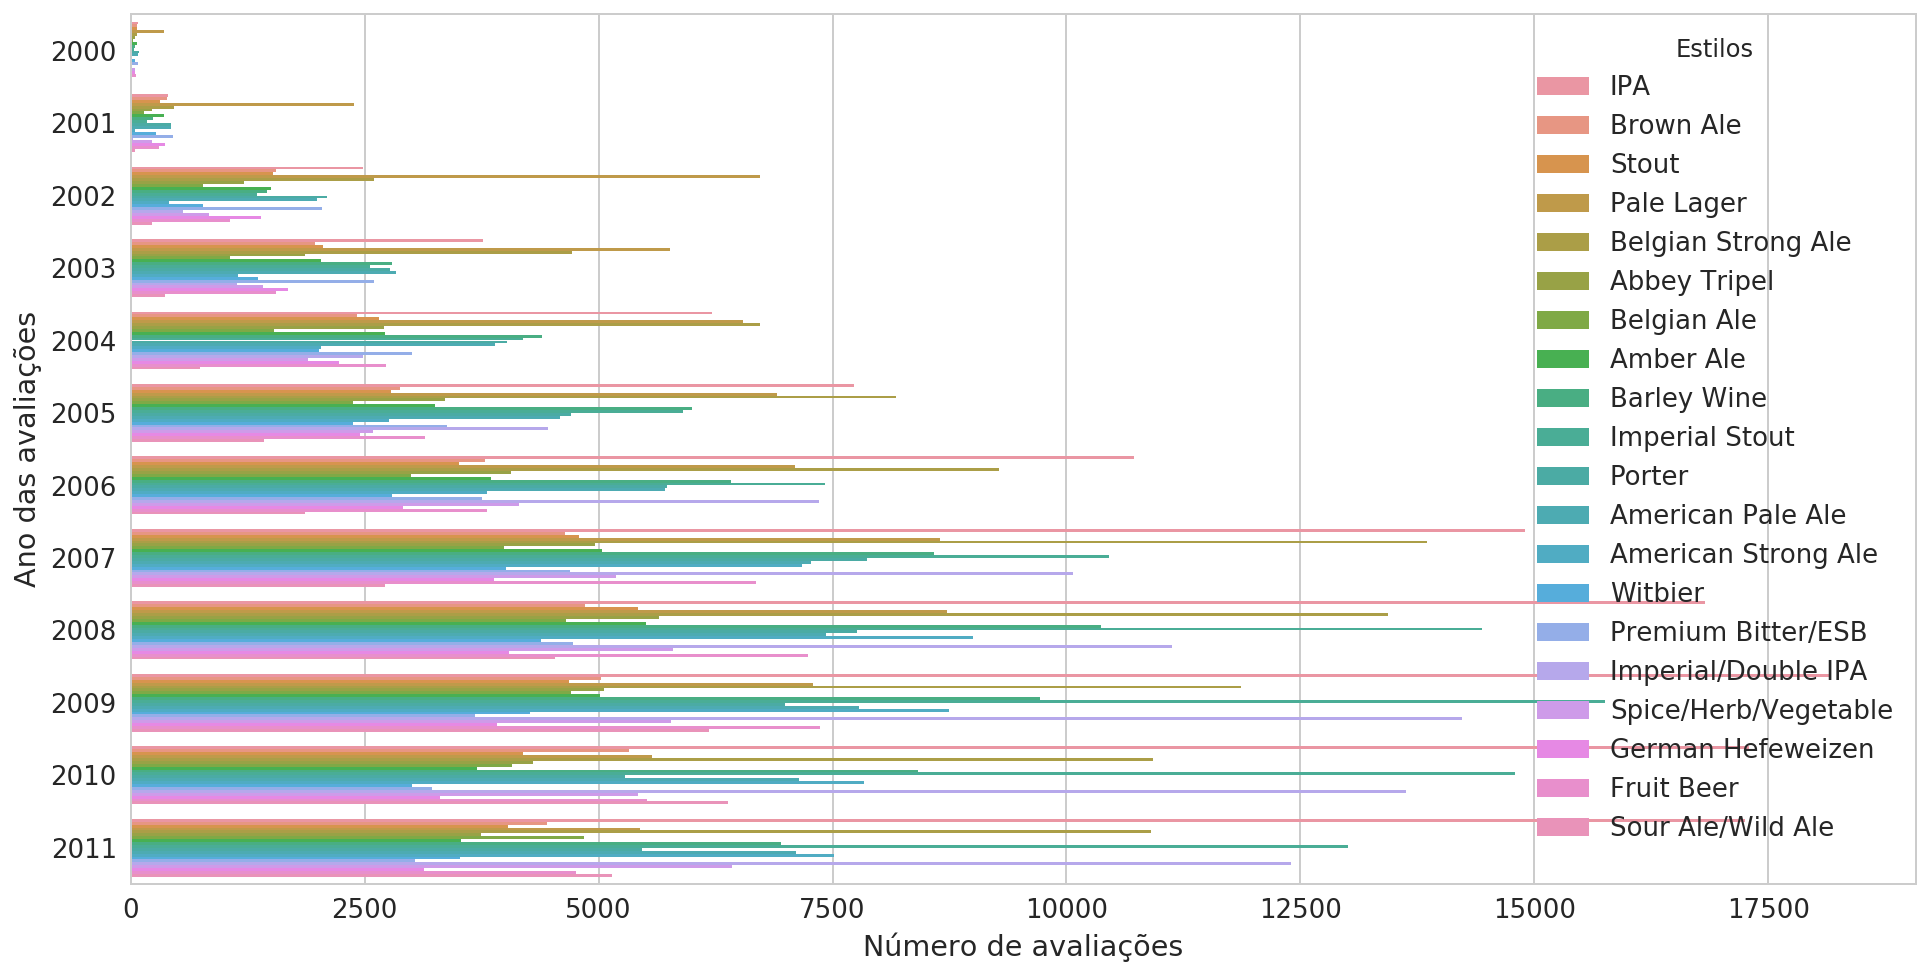

In [37]:
plt.figure(figsize=(16, 8))

sns.set(font_scale=1.3)  # tamanho fontes para eixos

%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")

G2 = sns.countplot(y='Review_Year',data=DF[DF['Beer_Style'].isin(ten_mst_rv_styles)],hue='Beer_Style');

leg = G2.get_legend()
new_title = 'Estilos'
leg.set_title(new_title)

G2.set(xlabel='Número de avaliações', ylabel='Ano das avaliações');

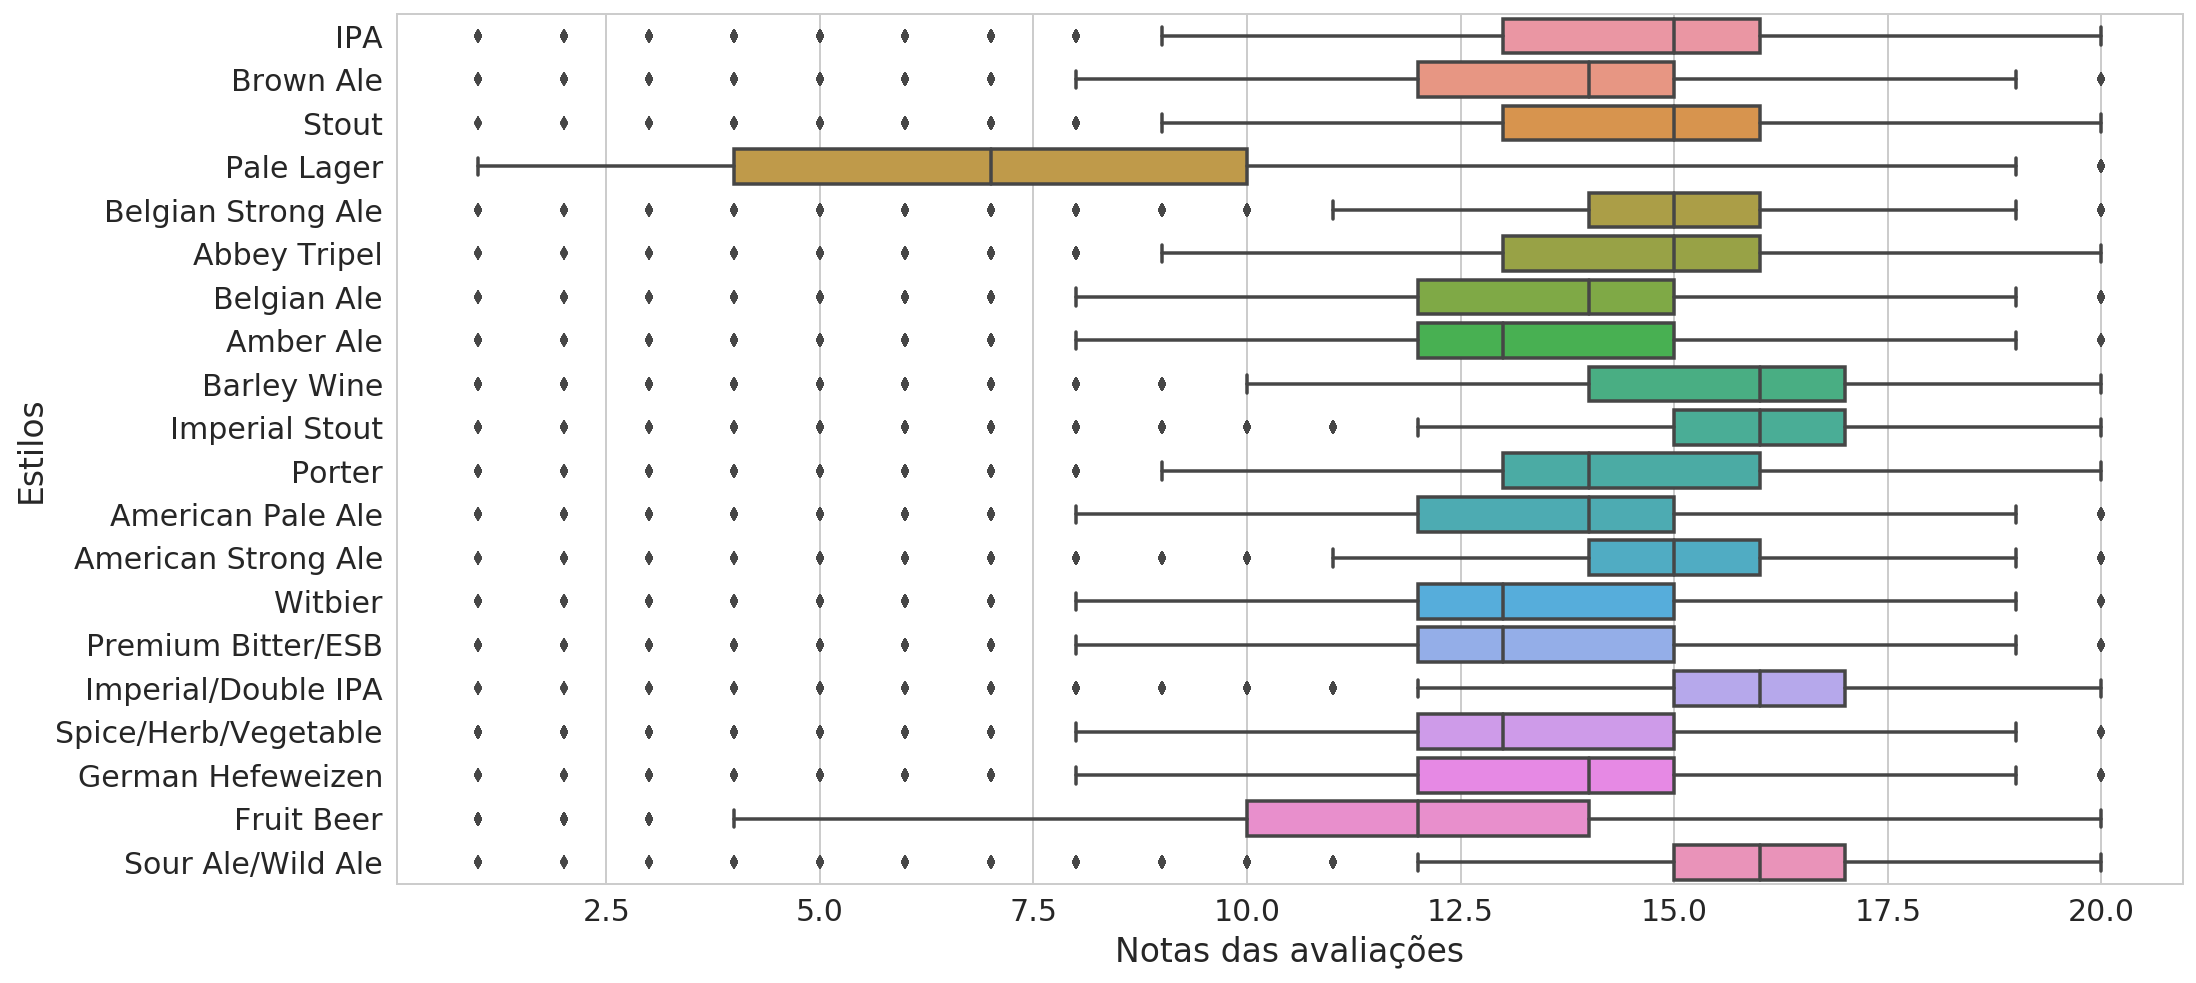

In [31]:
plt.figure(figsize=(16, 8))

sns.set(font_scale=1.5)  # tamanho fontes para eixos

%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")
G3=1

G3 = sns.boxplot(orient="h",y='Beer_Style',x="Review_Overall(20)",data=DF[DF['Beer_Style'].isin(ten_mst_rv_styles)])

#G3.set_xticklabels(G3.get_xticklabels(), rotation=40, ha="right")


G3.set(ylabel='Estilos', xlabel='Notas das avaliações');


In [ ]:
plt.figure(figsize=(30, 22.5))

sns.set(font_scale=2.1)  # tamanho fontes para eixos

%config InlineBackend.figure_format = 'retina'

G2 = sns.countplot(x='Review_Month',data=DF[DF['Beer_Style'].isin(ten_mst_rv_styles)],hue='Review_Year');


In [ ]:
DF.groupby(['Review_ProfileName','Beer_Name']).count()

In [ ]:
DF.info(memory_usage='deep')

In [ ]:
DF['Review_ProfileName'].nunique(), DF['Beer_Name'].nunique()

In [ ]:
for dtype in ['float','int','object']:
    selected_dtype = DF.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

In [ ]:
DF.info(memory_usage='deep')

In [ ]:
BARRIER

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(DF.drop('Review_Overall',axis=1), DF['Review_Overall'], test_size=0.33, random_state=42)

# nDCG

In [27]:
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [28]:
def nDCG2 (Algo, RecList, TestList, N):
    nDCGList={}
    nDCGList[Algo]={}
    nDCGList['fold']={}
    nDCGList['N']={}
    for i in range(len(RecList)):
        i=i+1
        nDCGList[Algo][i-1]=[]
        nDCGList['fold'][i-1]=i
        nDCGList['N'][i-1]=N
        #print('Fold ',i,'\n\n')
        for j in range(N):#len(RecList[i])):
            Rel=[]
            #print('\nUsuario: ',j+1)
            #print('Rec:',RecList[i][j])
            #print('\nTest:', TestList[i][j])

            for x in RecList[i][j]:
                if x in TestList[i][j]:
                    Rel.append(1)
                else:
                    Rel.append(0)

            #print('\nRel:' ,Rel)

            #for k in range(N):
            nDCGList[Algo][i-1].append(ndcg_at_k(Rel,N))
            mean=np.mean(nDCGList[Algo][i-1])
            #print('nDCG: ',mean,'\n\n')
            del nDCGList[Algo][i-1][:]
            nDCGList[Algo][i-1].append(mean)
            #print(nDCGList[Algo][i])
        #print('****************************************************************************************************')
        mean=np.mean(nDCGList[Algo][i-1])
        #print('Fold: ',i,'nDCG mean: ',mean,'\n\n')
        del nDCGList[Algo][i-1][:]
        nDCGList[Algo][i-1]=mean
    
    return nDCGList

# K-Fold Cross Validation

In [29]:
def getTest(row,fold):

    UR_test=[]
    fold=fold-1
    pct=0.2
    likedByUser = row['Beer List'].copy()
    end = len(likedByUser)
    end = int(end - (pct*fold))
    #print('likedByUser', likedByUser)
    pctValue=int(end*(pct))
    #print('pctValue: ',pctValue)
    likedByUser = likedByUser[end-pctValue:end+1]
    #print('likedByUser Test', likedByUser)
    #UR_train = np.delete(likedByUser, np.s_[end-pct:end+1], axis=1)
    for element in likedByUser:
        try:
            element=int(element)
        except:
            pass
        else:
            UR_test.append(element)
    return UR_test

In [30]:
def getTrain(UR, fold):
    BeerID=DF['Beer_ID'].unique().tolist()
    M = np.zeros(shape=(len(UR),len(BeerID)+1))
    fold=fold-1
    pct=0.2

    for i, row in UR.iterrows():
        likedByUser = row['Beer List'].copy()
        end = len(likedByUser)
        end = int(end - (pct*fold))
        pctValue=int(end*(pct))
        del likedByUser[end-pctValue:end+1]
        for j in range(len(likedByUser)):
            try:
                element=int(likedByUser[j])
            except:
                pass
            else:
                #print(i,element)
                #score = DF[(DF['User_ID']==i) & (DF['Beer_ID']==element)]['Review_Overall(20)'].values[0]
                M[i,element] = 1
    return M

# Content-Based

In [129]:
def ContentBased(user_row_number, foldNum,  tfidf_matrix, tfidf_vectorizer):
    likedByUser=[int(element) for element in UR.iloc[user_row_number]['Beer List']]
    foldNum=foldNum-1
    pct=0.2
    end = len(likedByUser)
    end = int(end - (pct*foldNum))
    pctValue=int(end*(pct))
    del likedByUser[end-pctValue:end+1]

    nbrs_tfidf        = NearestNeighbors(n_neighbors=100+1,metric='cosine',algorithm='auto').fit(tfidf_matrix)

    distances, indices = nbrs_tfidf.kneighbors(getTFIDFUser(user_row_number, tfidf_vectorizer))
    titles_similar      = pd.Series(indices.flatten()).map(DF.reset_index()['Beer_ID'])
    result             = pd.DataFrame({'distance':distances.flatten(), 'Beer_ID':titles_similar})
    return result[~result['Beer_ID'].isin(likedByUser)]

In [130]:
def getTFIDFUser(rowNumber, tfidf_vectorizer):
    UserBeerList=UR.iloc[rowNumber]['Beer List']
    AllString=''
    for i in range(len(UserBeerList)):
        element=int(UserBeerList[i])
        try:
            rawAbstract=DF[DF['Beer_ID']==element]['Review_Text'].values[0]
        except:
            rawAbstract=''
        AllString=AllString+rawAbstract
        tfidf_matrix = tfidf_vectorizer.transform([AllString])

    return tfidf_matrix

In [131]:
def CB(RecListCB,TestListCB):
    fold=1

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(DF['Review_Text'])

    while fold < 6:

        RecListCB[fold]=[]
        TestListCB[fold]=[]

        print('Fold: ',fold)

        for user_row_number in range(len(UR)):

            UR_test = getTest(UR.iloc[user_row_number],fold)

            sorted_user_predictions = ContentBased(user_row_number,fold, tfidf_matrix, tfidf_vectorizer)

            TestListCB[fold].append(UR_test)

            rec=sorted_user_predictions[0:100]['Beer_ID'].tolist()

            RecListCB[fold].append(rec)

        int(fold)
        fold=fold+1
    return RecListCB, TestListCB

In [132]:
RecListCB={}
TestListCB={}

In [133]:
RecListCB,TestListCB = CB(RecListCB,TestListCB)

Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5


In [193]:
Top1=pd.DataFrame(nDCG2('Content Based',RecListCB,TestListCB,1))
Top5=pd.DataFrame(nDCG2('Content Based',RecListCB,TestListCB,5))
Top10=pd.DataFrame(nDCG2('Content Based',RecListCB,TestListCB,10))
Top20=pd.DataFrame(nDCG2('Content Based',RecListCB,TestListCB,20))
Top50=pd.DataFrame(nDCG2('Content Based',RecListCB,TestListCB,50))
#Top100=pd.DataFrame(nDCG2('Content Based',RecListCB,TestListCB,100))

All2=Top1.append([Top5,Top10,Top20,Top50],ignore_index=True)

#All2.to_csv('CB.csv')

In [194]:
CBmean=[]
for i in [1,5,10,20,50,100]:
    CBmean.append(All2[All2['N']==i].mean().to_dict())

In [195]:
CB = pd.DataFrame(CBmean)

In [138]:
#CB.to_csv('CB.csv')

In [197]:
CB.rename(columns={'N':'Top-N'}).iplot(xTitle='Número de recomendações',yTitle='Valor nDCG',x='Top-N',y=['Content Based'],size=8,theme='white',mode='lines+markers',symbol=['dot'],dash=['dot'],color='orange')

# Collaborative Filtering

In [170]:
def CF(RecListCF,TestListCF):

    fold=1

    while fold < 6:

        RecListCF[fold]=[]
        TestListCF[fold]=[]
        #name = 'preds'+'Fold'+str(fold)+'.csv'
        #preds_df = pd.read_csv(name)
        #preds_df.drop('Unnamed: 0',axis=1,inplace=True)

        UR_train = getTrain(UR, fold)#np.delete(M, np.s_[end-twpct:end+1], axis=1) # remove columns 1 and 2

        U, sigma, Vt = svds(UR_train, k = 500)

        sigma = np.diag(sigma)

        #print(U.shape,Vt.shape)
        print ("Fold: ",fold)
        all_user_predicted_ratings = (np.dot(np.dot(U, sigma), Vt))

        preds_df = pd.DataFrame(all_user_predicted_ratings)
        preds_df.drop(0,inplace=True,axis=1)
        for user_row_number in range(len(UR)):

            sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False).index.tolist()
            UR_test = getTest(UR.iloc[user_row_number],fold)
            TestListCF[fold].append(UR_test)
            rec = sorted_user_predictions[0:100]
            RecListCF[fold].append(rec)
        fold=fold+1

    return RecListCF, TestListCF

In [171]:
RecListCF={}
TestListCF={}

In [172]:
RecListCF,TestListCF = CF(RecListCF,TestListCF)

Fold:  1
Fold:  2
Fold:  3
Fold:  4
Fold:  5


In [188]:
Top1=pd.DataFrame(nDCG2('Collaborative Filtering',RecListCF,TestListCF,1))
Top5=pd.DataFrame(nDCG2('Collaborative Filtering',RecListCF,TestListCF,5))
Top10=pd.DataFrame(nDCG2('Collaborative Filtering',RecListCF,TestListCF,10))
Top20=pd.DataFrame(nDCG2('Collaborative Filtering',RecListCF,TestListCF,20))
Top50=pd.DataFrame(nDCG2('Collaborative Filtering',RecListCF,TestListCF,50))
#Top100=pd.DataFrame(nDCG2('Collaborative Filtering',RecListCF,TestListCF,100))

All=Top1.append([Top5,Top10,Top20,Top50],ignore_index=True)

#All.to_csv('CF.csv')

In [189]:
CFmean=[]
for i in [1,5,10,20,50,100]:
    CFmean.append(All[All['N']==i].mean().to_dict())

In [190]:
CF = pd.DataFrame(CFmean)

In [191]:
CF.to_csv('CF.csv')

In [192]:
CF.rename(columns={'N':'Top-N'}).iplot(xTitle='Número de recomendações',yTitle='Valor nDCG',x='Top-N',y=['Collaborative Filtering'],size=8,theme='white',mode='lines+markers',symbol=['dot'],dash=['line'],color='blue')

# Hybrid

In [ ]:
def CombineResults(sorted_user_predictionsCB, sorted_user_predictionsCF):

    x = sorted_user_predictionsCB['similarity'].values.reshape(-1,1) #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    sorted_user_predictionsCB['similarity'] = x_scaled

    sorted_user_predictionsCF.rename('similarity',inplace=True);
    sorted_user_predictionsCF = pd.DataFrame(sorted_user_predictionsCF)

    x = sorted_user_predictionsCF['similarity'].values.reshape(-1,1) #returns a numpy array
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    sorted_user_predictionsCF['similarity'] = x_scaled

    MList1=sorted_user_predictionsCB['Beer_ID'].tolist()
    MList2=sorted_user_predictionsCF.index.values.tolist()
    MList=MList1+MList2
    MList=list(set(MList))

    MDictList=[None]*len(MList)
    for i in range(len(MList)):
        MDict={}
        element=MList[i]
        MDict['Beer_ID'] = element
        valueCB=0
        valueCF=0
        try:
            valueCB=sorted_user_predictionsCB[sorted_user_predictionsCB['Beer_ID']==element]['similarity'].values[0]
        except:
            pass
        try:
            valueCF=sorted_user_predictionsCF.iloc[element]['similarity']
        except:
            pass
        MDict['value'] = valueCB+valueCF
        MDictList[i] = MDict
    A=pd.DataFrame(MDictList)
    A=A.sort_values(by=['value'],ascending=False)
    RecList = A[0:100]['Beer_ID'].tolist()

    return RecList

In [ ]:
def Hybrid(RecListHibr, TestListHibr):

    fold=1

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(DF['Review_Text'])

    while fold < 6:

        UR_train = getTrain(UR, fold)

        U, sigma, Vt = svds(UR_train, k = 500)

        sigma = np.diag(sigma)

        print(U.shape,Vt.shape)

        all_user_predicted_ratings = (np.dot(np.dot(U, sigma), Vt))

        preds_df = pd.DataFrame(all_user_predicted_ratings)
        preds_df.drop(0,inplace=True,axis=1)

        RecListHibr[fold]=[]
        TestListHibr[fold]=[]

        print('Fold: ',fold)

        for user_row_number in range(len(UR)):

            UR_test = getTest(UR.iloc[user_row_number],fold)

            sorted_user_predictionsCF = preds_df.iloc[user_row_number].sort_values(ascending=False)
            sorted_user_predictionsCB = ContentBased(user_row_number,fold, tfidf_matrix, tfidf_vectorizer)
            sorted_user_predictionsCB['similarity'] = 1-sorted_user_predictionsCB['distance']

            rec=CombineResults(sorted_user_predictionsCB[0:100].copy(), sorted_user_predictionsCF[0:100].copy())

            TestListHibr[fold].append(UR_test)

            RecListHibr[fold].append(rec)

        int(fold)
        fold=fold+1
    return RecListHibr, TestListHibr

RecListHibr={}
TestListHibr={}

RecListHibr,TestListHibr = Hybrid(RecListHibr,TestListHibr)

Top1=pd.DataFrame(nDCG2('Hybrid',RecListHibr,TestListHibr,1))
Top5=pd.DataFrame(nDCG2('Hybrid',RecListHibr,TestListHibr,5))
Top10=pd.DataFrame(nDCG2('Hybrid',RecListHibr,TestListHibr,10))
Top20=pd.DataFrame(nDCG2('Hybrid',RecListHibr,TestListHibr,20))
Top50=pd.DataFrame(nDCG2('Hybrid',RecListHibr,TestListHibr,50))
Top100=pd.DataFrame(nDCG2('Hybrid',RecListHibr,TestListHibr,100))

All3=Top1.append([Top5,Top10,Top20,Top50,Top100],ignore_index=True)

All3.to_csv('Hibr.csv')

# Results

In [54]:
CF=pd.read_csv('CF.csv').rename(columns={'N':'Top-N'}).drop('Unnamed: 0',axis=1)

In [73]:
CFmean=[]
for i in [1,5,10,20,50,100]:
    CFmean.append(CF[CF['Top-N']==i].mean().to_dict())

In [74]:
pd.DataFrame(CFmean).to_csv('CF2.csv')

In [71]:
A.iplot(xTitle='Número de recomendações',yTitle='Valor nDCG',x='Top-N',y=['Collaborative Filtering'],size=8,theme='white',mode='lines+markers',symbol=['dot'],dash=['line'],color='blue')

In [56]:
CF.iplot(xTitle='Número de recomendações',yTitle='Valor nDCG',x='Top-N',y=['Collaborative Filtering'],size=8,theme='white',mode='lines+markers',symbol=['dot'],dash=['line'],color='blue')